# Collect Data and Train Gaussian Processes - Retraining

## Gaussian Processes

In [1]:
import torch
import gpytorch
import numpy as np

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000, device=None):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        Y = torch.tensor(Y, dtype=torch.float32, device=self.device).flatten()  # ensure 1D

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        Mantiene todos los tensores en self.device (CPU o CUDA).
        """
        # --------- Convertir entrada a tensores en el device correcto ---------
        # X_new
        if not torch.is_tensor(X_new):
            X_new = torch.as_tensor(X_new, dtype=torch.float32, device=self.device)
        else:
            X_new = X_new.to(self.device, dtype=torch.float32)

        # Y_new
        if not torch.is_tensor(Y_new):
            Y_new = torch.as_tensor(Y_new, dtype=torch.float32, device=self.device)
        else:
            Y_new = Y_new.to(self.device, dtype=torch.float32)

        Y_new = Y_new.flatten()  # [N]

        # --------- Asegurar que X_train / Y_train sean tensores ---------
        # X_train
        if isinstance(self.X_train, list) or self.X_train is None:
            # Primera vez: no concatenamos, simplemente asignamos
            self.X_train = X_new
        else:
            self.X_train = torch.cat([self.X_train, X_new], dim=0)

        # Y_train
        if isinstance(self.Y_train, list) or self.Y_train is None:
            self.Y_train = Y_new
        else:
            if self.Y_train.ndim > 1:
                self.Y_train = self.Y_train.flatten()
            self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        # --------- Reentrenar si toca ---------
        if retrain:
            self.retrain()


    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        # self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        # self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        self.X_mean = self.X_train.mean(0)
        self.X_std = self.X_train.std(0) + 1e-8
        self.Y_mean = self.Y_train.mean(0)
        self.Y_std = self.Y_train.std(0) + 1e-8

        self.Xn = (self.X_train - self.X_mean) / self.X_std
        self.Yn = (self.Y_train - self.Y_mean) / self.Y_std

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.detach().cpu().numpy()
        Y_train = self.Y_train.detach().cpu().numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(self.device)
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1]
                                  ).to(self.device)

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean * self.Y_std + self.Y_mean
            var = pred.variance * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean.detach().cpu().numpy(), var.detach().cpu().numpy()


## Recolección de datos

Using device: cuda
✅ Simulador inicializado correctamente.


Rollout MuJoCo: 100%|██████████| 100/100 [00:00<00:00, 6415.07it/s]

✅ Datos recolectados:
  states     : (100, 6)
  actions    : (100, 2)
  delta_s    : (100, 6)
✅ Dataset para GP:
  X: (25, 8)  (state+action)
  Y: (25, 6)  (delta_state)


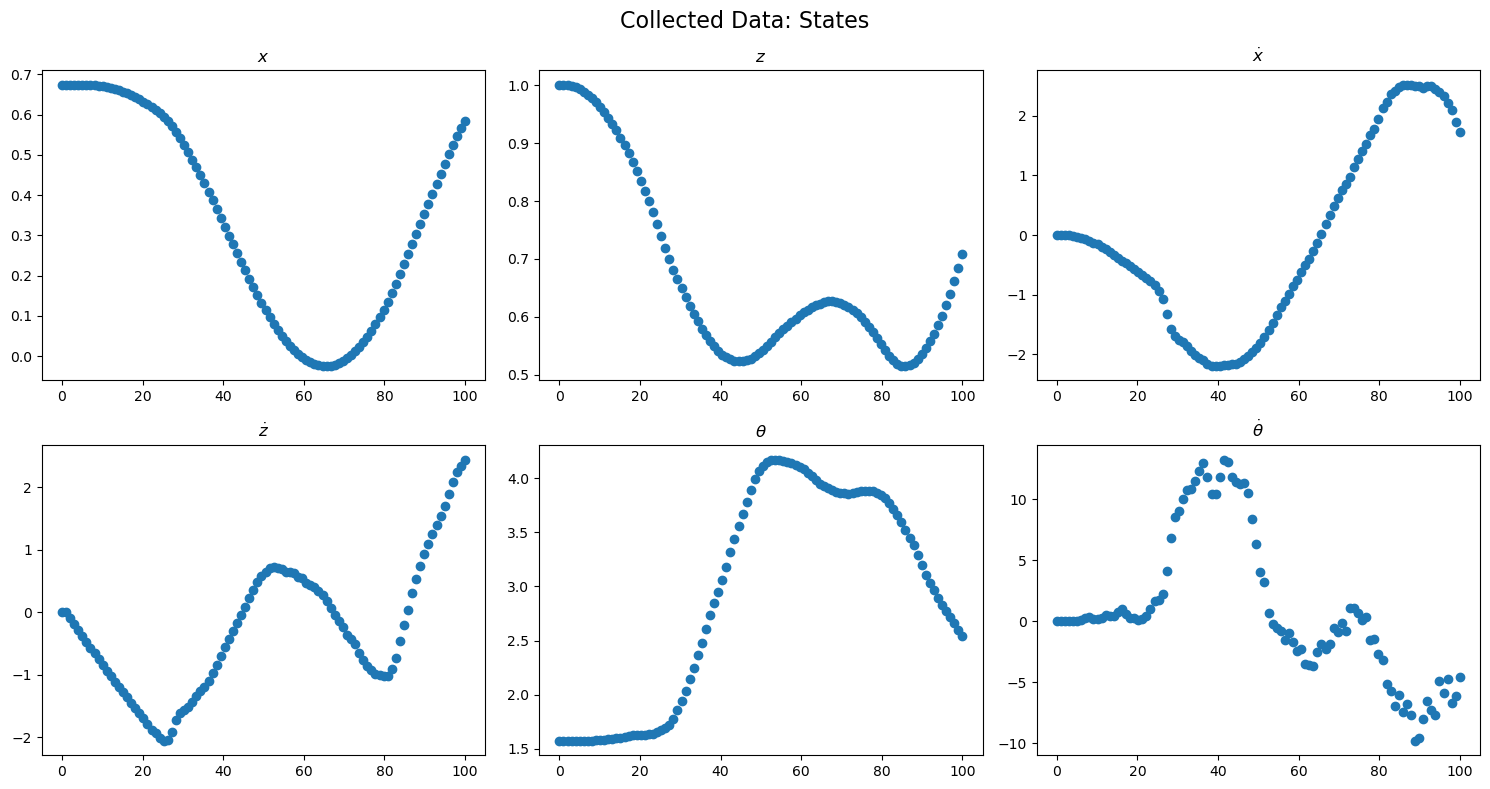

In [2]:
# ===============================================
# 1. Imports y setup MuJoCo + Torch
# ===============================================
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # solo para evitar el warning de OpenMP

import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from models.cantilever_2d_drone import get_xml  # tu generador XML

# Opcional: elegir device para Torch (aunque GPManager original trabaja en CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ===============================================
# 2. Crear modelo MuJoCo a partir del XML
# ===============================================
XML = get_xml(num_segmentos=8, longitud_total=0.6)
model = mj.MjModel.from_xml_string(XML)
data = mj.MjData(model)

print("✅ Simulador inicializado correctamente.")

# ===============================================
# 3. Utilidades para ángulos y estado del dron
# ===============================================

def unwrap_angle(angle_raw, angle_prev):
    """
    Devuelve un ángulo continuo, sin saltos bruscos de ±2π.
    """
    if angle_prev is None:
        return angle_raw

    delta = angle_raw - angle_prev
    if delta > np.pi:
        angle_raw -= 2 * np.pi
    elif delta < -np.pi:
        angle_raw += 2 * np.pi
    return angle_raw


def quat_to_roll_x(quat, prev_roll=None):
    """
    Convierte cuaternión [w,x,y,z] a ángulo de roll alrededor de X,
    y lo hace continuo usando unwrap.
    """
    w, x, y, z = quat

    # roll (X)
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll_raw = np.arctan2(sinr_cosp, cosr_cosp)

    roll_cont = unwrap_angle(roll_raw, prev_roll)
    return roll_cont


def get_state_from_sensors(data, prev_theta=None):
    """
    Construye el vector de estado:
        s = [x, z, x_dot, z_dot, theta, theta_dot]
    a partir de los sensores definidos en el XML.
    """
    # Posición global
    pos = data.sensor("pos_drone").data  # [x, y, z]
    x, z = pos[0], pos[2]

    # Velocidades lineales
    linvel = data.sensor("linvel_drone").data  # [vx, vy, vz]
    x_dot = linvel[0]
    z_dot = linvel[2]

    # Cuaternión del dron
    quat = data.sensor("quat_drone").data   # [w, x, y, z]
    roll_raw = quat_to_roll_x(quat, prev_theta)

    # Velocidad angular (rotvel_drone)
    angvel = data.sensor("rotvel_drone").data  # [wx, wy, wz]
    theta_dot = angvel[1]  # roll alrededor de 

    theta = roll_raw
    state = np.array([x, z, x_dot, z_dot, theta, theta_dot], dtype=np.float32)
    return state, theta

# ===============================================
# 4. Rollout aleatorio para recolectar datos
# ===============================================

def rollout_random(model, data, n_steps=5000):
    """
    Ejecuta el simulador con acciones aleatorias y devuelve:
        states:      [N, 6]
        actions:     [N, 2]
        next_states: [N, 6]
    """
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    states, actions, next_states = [], [], []
    prev_theta = None

    for step in tqdm(range(n_steps), desc="Rollout MuJoCo"):
        # Estado actual
        s_t, prev_theta = get_state_from_sensors(data, prev_theta)

        # Acción aleatoria en rango [0, 2], y la escalamos suave con el tiempo para no excitar demasiado al inicio
        scale = (step / n_steps)  # va de 0 → 1
        a_t = np.random.uniform(0.0, 2.0 * scale + 1e-3, size=2).astype(np.float32)
        data.ctrl[:] = a_t

        # Avanzar simulación un paso
        mj.mj_step(model, data)

        # Estado siguiente
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        states.append(s_t)
        actions.append(a_t)
        next_states.append(s_next)

    states = np.stack(states, axis=0)
    actions = np.stack(actions, axis=0)
    next_states = np.stack(next_states, axis=0)

    return states, actions, next_states


# ===============================================
# 5. Recolectar datos y construir dataset (X, Y)
# ===============================================

N_STEPS = 100  # puedes jugar con este número; cuidado con GPs (O(N^3))
states, actions, next_states = rollout_random(model, data, n_steps=N_STEPS)

delta_s = next_states - states  # [N, 6]

print("✅ Datos recolectados:")
print("  states     :", states.shape)
print("  actions    :", actions.shape)
print("  delta_s    :", delta_s.shape)

# Construimos entradas X = [state, action]
X_np = np.concatenate([states, actions], axis=1).astype(np.float32)   # [N, 8]
Y_np = delta_s.astype(np.float32)                                     # [N, 6]

# Opcional: subsampling para que el GP sea manejable
SUBSAMPLE = 4  # usar cada k-ésimo dato
X_np = X_np[::SUBSAMPLE]
Y_np = Y_np[::SUBSAMPLE]

print("✅ Dataset para GP:")
print("  X:", X_np.shape, " (state+action)")
print("  Y:", Y_np.shape, " (delta_state)")


# ===============================================
# 6. Visualización de los datos recolectados
# ===============================================

rng = N_STEPS
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$x$', r'$z$', r'$\dot{x}$', r'$\dot{z}$', r'$\theta$', r'$\dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(np.linspace(0,rng,rng),states[0:rng,i])
    ax.set_title(f"{labels[i]}")

plt.suptitle("Collected Data: States", fontsize=16)
plt.tight_layout()
plt.show()


## GP Training

In [3]:
import os
import torch

MODEL_DIR = "data/gp_torch_models"
os.makedirs(MODEL_DIR, exist_ok=True)


def save_gp(gp, filepath):
    checkpoint = {
        "model_state": gp.model.state_dict(),
        "likelihood_state": gp.likelihood.state_dict(),
        "X_mean": gp.X_mean,
        "X_std": gp.X_std,
        "Y_mean": gp.Y_mean,
        "Y_std": gp.Y_std,
        "kernel": gp.kernel
    }
    torch.save(checkpoint, filepath)
    print(f"💾 GP guardado en {filepath}")


def load_gp(gp, filepath, X_example):
    checkpoint = torch.load(filepath, map_location=gp.device)

    gp.X_mean = checkpoint["X_mean"]
    gp.X_std = checkpoint["X_std"]
    gp.Y_mean = checkpoint["Y_mean"]
    gp.Y_std = checkpoint["Y_std"]

    gp.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(gp.device)

    gp.model = ExactGPModel(
        X_example,
        torch.zeros(len(X_example), device=gp.device),
        gp.likelihood,
        kernel=checkpoint["kernel"],
        ard_dims=X_example.shape[-1]
    ).to(gp.device)

    gp.model.load_state_dict(checkpoint["model_state"])
    gp.likelihood.load_state_dict(checkpoint["likelihood_state"])

    gp.model.eval()
    gp.likelihood.eval()
    gp.trained = True

    print(f"📂 GP cargado desde {filepath}")



# ===============================================
# 6. Entrenar o cargar modelos GP
# ===============================================

state_dim = Y_np.shape[1]   # 6
gps = []

for d in range(state_dim):
    gp_path = os.path.join(MODEL_DIR, f"gp_retrained_dim{d}.pth")
    gp = GPManager(kernel='RBF', iters=300)

    if os.path.exists(gp_path):
        print(f"📦 Cargando GP para dimensión {d}...")
        X_example = torch.tensor(X_np, dtype=torch.float32)
        load_gp(gp, gp_path, X_example)
    else:
        print(f"🧠 Entrenando GP para dimensión {d}...")
        gp.fit(X_np, Y_np[:, d])
        save_gp(gp, gp_path)

    gps.append(gp)

print("🎉 Todos los GPs listos (cargados o entrenados).")


# ===============================================
# 7. Función de predicción de un paso con el modelo GP
# ===============================================

def gp_dynamics_step(gps, state, action):
    """
    Calcula s_{t+1} = s_t + Δs usando la familia de GPs.
    state:  [6]  (numpy o torch)
    action: [2]
    """
    if isinstance(state, torch.Tensor):
        state = state.detach().cpu().numpy()
    if isinstance(action, torch.Tensor):
        action = action.detach().cpu().numpy()

    x = np.concatenate([state, action], axis=-1)[None, :]  # [1, 8]
    delta_pred = []

    for d, gp in enumerate(gps):
        mean_d, _ = gp.predict(x)   # mean_d: [1]
        delta_pred.append(mean_d[0])

    delta_pred = np.array(delta_pred, dtype=np.float32)  # [6]
    next_state_pred = state + delta_pred
    return next_state_pred, delta_pred

# Ejemplo rápido de uso:
s0 = states[0]
a0 = np.array([0.5, 0.5], dtype=np.float32)
s1_pred, ds_pred = gp_dynamics_step(gps, s0, a0)
print("Estado inicial s0:", s0)
print("Acción a0        :", a0)
print("Δs (GP)          :", ds_pred)
print("s1 (GP)          :", s1_pred)


🧠 Entrenando GP para dimensión 0...
💾 GP guardado en data/gp_torch_models\gp_retrained_dim0.pth
🧠 Entrenando GP para dimensión 1...
💾 GP guardado en data/gp_torch_models\gp_retrained_dim1.pth
🧠 Entrenando GP para dimensión 2...
💾 GP guardado en data/gp_torch_models\gp_retrained_dim2.pth
🧠 Entrenando GP para dimensión 3...
💾 GP guardado en data/gp_torch_models\gp_retrained_dim3.pth
🧠 Entrenando GP para dimensión 4...
💾 GP guardado en data/gp_torch_models\gp_retrained_dim4.pth
🧠 Entrenando GP para dimensión 5...
💾 GP guardado en data/gp_torch_models\gp_retrained_dim5.pth
🎉 Todos los GPs listos (cargados o entrenados).
Estado inicial s0: [0.675     1.00125   0.        0.        1.5707964 0.       ]
Acción a0        : [0.5 0.5]
Δs (GP)          : [ 0.00039476  0.00036299 -0.06213656 -0.05889266  0.00261087 -0.23663293]
s1 (GP)          : [ 0.6753948   1.001613   -0.06213656 -0.05889266  1.5734073  -0.23663293]


## Visualization

⚙️ Calculando predicciones GP (una sola vez)...
✅ Predicciones GP precomputadas.

🚀 Generando figuras de comparación compactas (2x3 por tipo)...


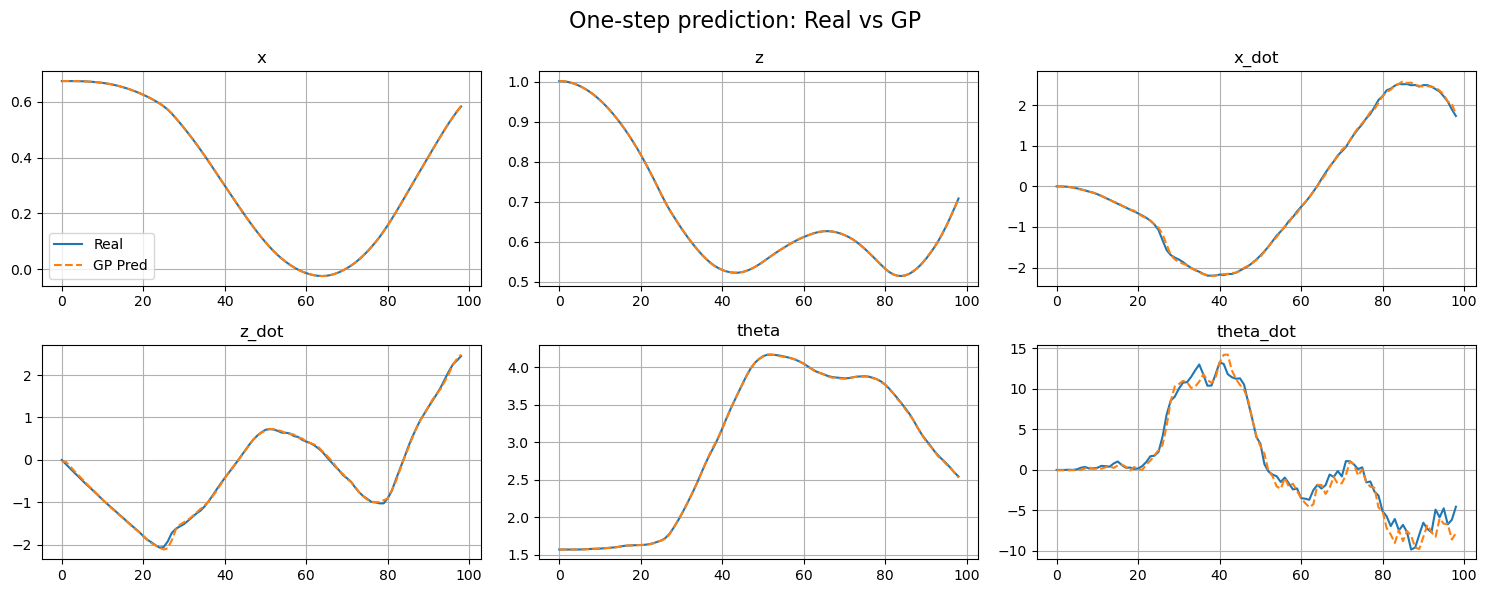

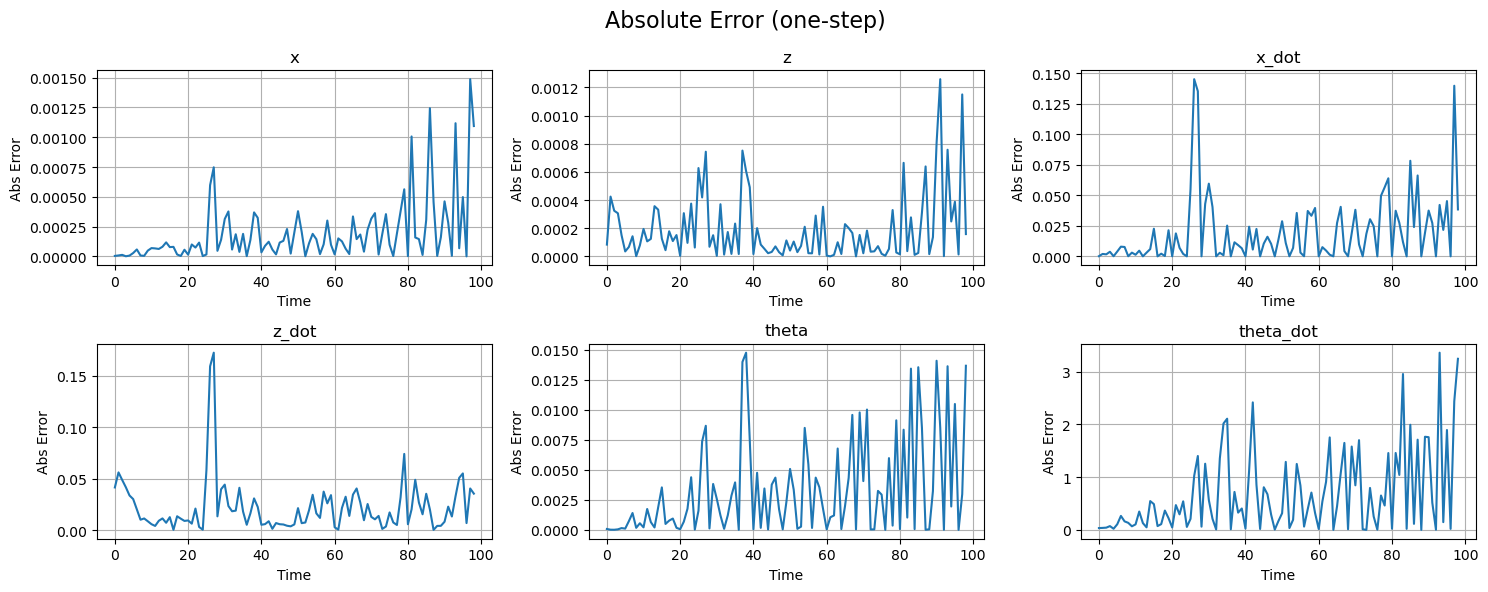

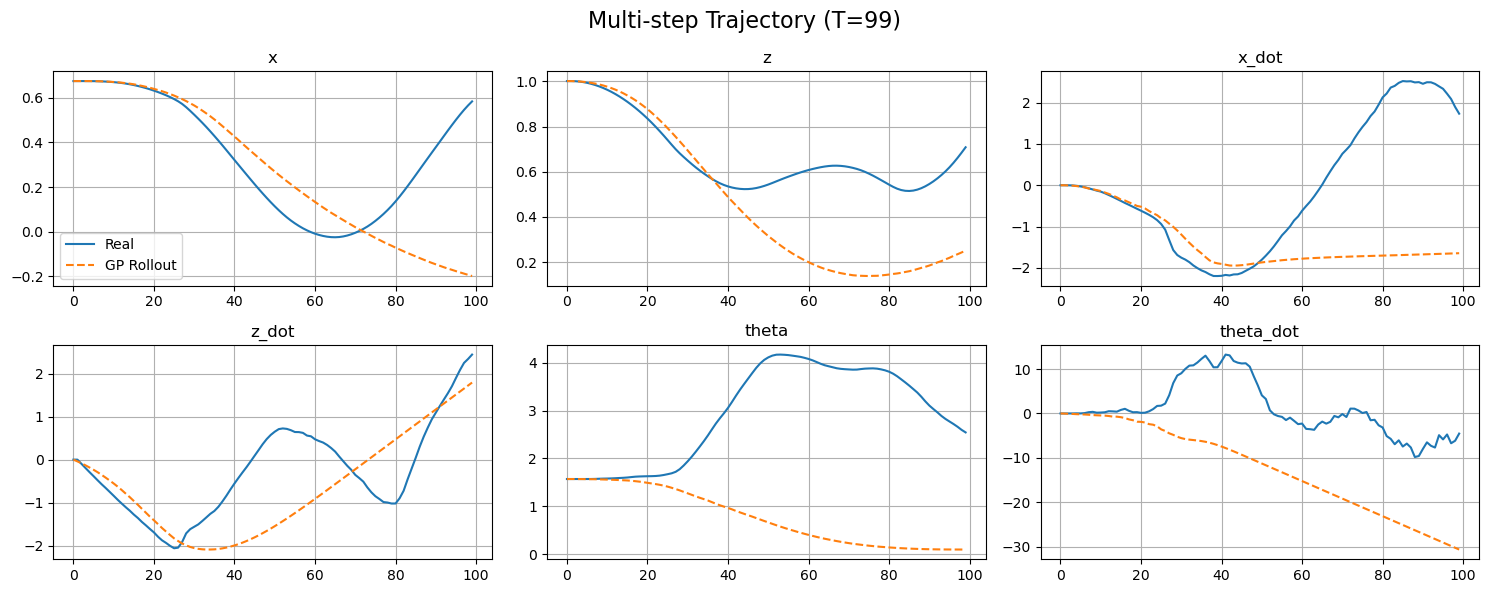

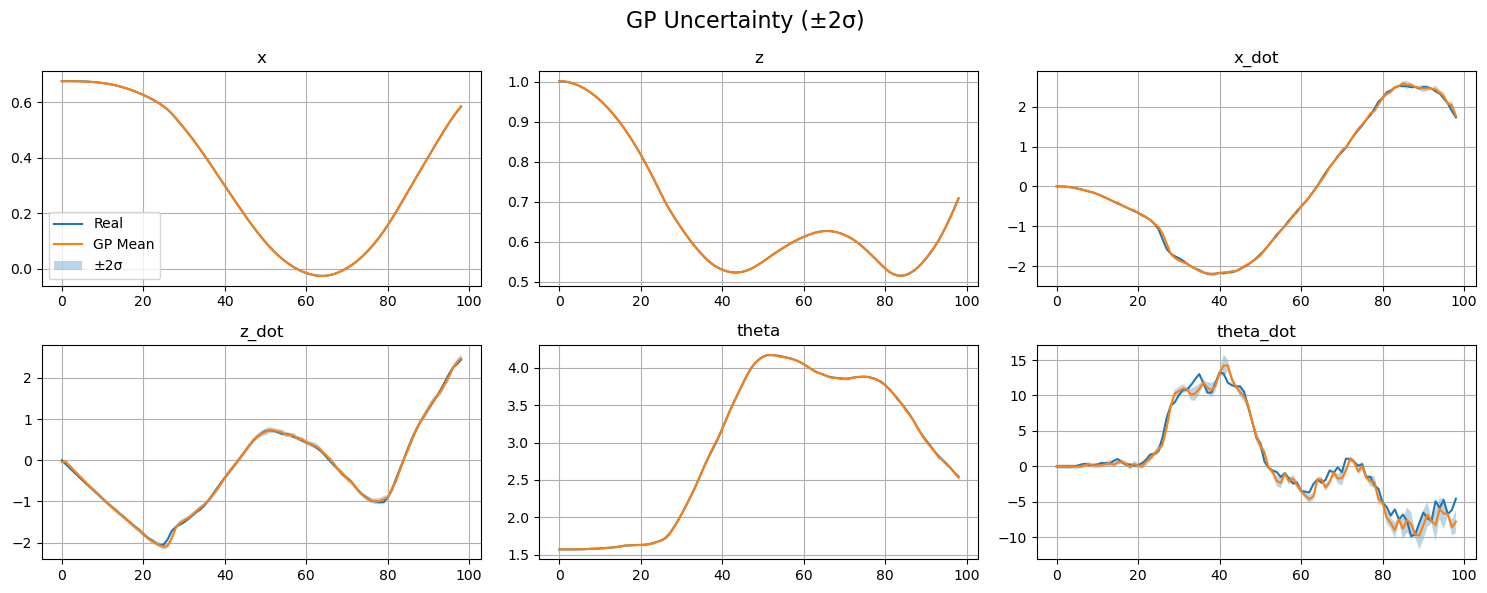


📊 MÉTRICAS DE REGRESIÓN POR DIMENSIÓN
         x | RMSE=0.000372 | MAE=0.000211 | R²=1.0000
         z | RMSE=0.000326 | MAE=0.000202 | R²=1.0000
     x_dot | RMSE=0.035390 | MAE=0.020562 | R²=0.9995
     z_dot | RMSE=0.034475 | MAE=0.022613 | R²=0.9990
     theta | RMSE=0.005252 | MAE=0.003317 | R²=1.0000
 theta_dot | RMSE=1.031621 | MAE=0.672613 | R²=0.9703


In [4]:
# ===============================================
# 8. PREDICCIONES GP PRECOMPUTADAS (UNA SOLA VEZ)
# ===============================================
import numpy as np
import matplotlib.pyplot as plt

DIM_LABELS = ["x", "z", "x_dot", "z_dot", "theta", "theta_dot"]

N, state_dim = states.shape

# Construir X_all = [state, action] para TODO el dataset
X_all = np.concatenate([states, actions], axis=1).astype(np.float32)   # [N, 8]

# mean_delta_all[d]: Δs_pred_dim_d, var_delta_all[d]: var(Δs_dim_d)
mean_delta_all = np.zeros((N, state_dim), dtype=np.float32)
var_delta_all  = np.zeros((N, state_dim), dtype=np.float32)

print("⚙️ Calculando predicciones GP (una sola vez)...")
for d, gp in enumerate(gps):
    m, v = gp.predict(X_all)          # m, v: [N]
    mean_delta_all[:, d] = m
    var_delta_all[:, d]  = v

# Predicción one-step del siguiente estado:
s_pred_all   = states + mean_delta_all           # [N, 6]  → s_{t+1}^{pred}
std_next_all = np.sqrt(var_delta_all)            # desv. estándar de s_{t+1}
print("✅ Predicciones GP precomputadas.")

# Parámetros de horizonte
ONE_STEP_T = 400      # pasos para one-step
ERROR_T    = 400      # pasos para error absoluto
TRAJ_T     = 100      # pasos multi-step rollout
UNC_T      = 100      # pasos para incertidumbre


# ===============================================
# 9. GRÁFICAS COMPACTAS (2x3) USANDO ARRAYS PRECOMPUTADOS
# ===============================================

# -----------------------------
# 9.1 One-step: Real vs GP
# -----------------------------
def plot_one_step_grid(next_states, s_pred_all, T=ONE_STEP_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        ax.plot(next_states[:T, d], label="Real")
        ax.plot(s_pred_all[:T, d], '--', label="GP Pred")
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle("One-step prediction: Real vs GP", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.2 Error absoluto
# -----------------------------
def plot_abs_error_grid(next_states, s_pred_all, T=ERROR_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    abs_err = np.abs(next_states - s_pred_all)   # [N, 6]

    for d in range(6):
        ax = axes[d]
        ax.plot(abs_err[:T, d])
        ax.set_title(DIM_LABELS[d])
        ax.set_xlabel("Time")
        ax.set_ylabel("Abs Error")
        ax.grid(True)

    fig.suptitle("Absolute Error (one-step)", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.3 Multi-step rollout
# -----------------------------
def rollout_gp(initial_state, actions, gps, T=TRAJ_T):
    T = min(T, len(actions)-1)
    s = initial_state.copy()
    traj = [s.copy()]
    for t in range(T):
        a = actions[t]
        s, _ = gp_dynamics_step(gps, s, a)
        traj.append(s.copy())
    return np.array(traj)   # [T+1, 6]


def plot_trajectory_grid(states, actions, gps, T=TRAJ_T):
    T = min(T, len(actions)-1)
    traj_gp = rollout_gp(states[0], actions, gps, T)  # [T+1, 6]

    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        ax.plot(states[:T+1, d], label="Real")
        ax.plot(traj_gp[:T+1, d], '--', label="GP Rollout")
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle(f"Multi-step Trajectory (T={T})", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.4 Incertidumbre (±2σ)
# -----------------------------
def plot_uncertainty_grid(next_states, s_pred_all, std_next_all, T=UNC_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        mean = s_pred_all[:T, d]
        std  = std_next_all[:T, d]

        ax.plot(next_states[:T, d], label="Real")
        ax.plot(mean, label="GP Mean")
        ax.fill_between(
            range(T),
            mean - 2*std,
            mean + 2*std,
            alpha=0.3,
            label="±2σ"
        )
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle("GP Uncertainty (±2σ)", fontsize=16)
    plt.tight_layout()
    plt.show()


# ===============================================
# 10. MÉTRICAS GLOBALES (RMSE, MAE, R²)
# ===============================================
def regression_metrics(next_states, s_pred_all):
    y_true = next_states
    y_pred = s_pred_all

    print("\n📊 MÉTRICAS DE REGRESIÓN POR DIMENSIÓN")
    print("===============================================")
    for d in range(y_true.shape[1]):
        diff = y_true[:, d] - y_pred[:, d]
        mse  = np.mean(diff**2)
        rmse = np.sqrt(mse)
        mae  = np.mean(np.abs(diff))

        var_y = np.var(y_true[:, d])
        if var_y < 1e-12:
            r2 = float('nan')
        else:
            r2 = 1.0 - mse / var_y

        print(f"{DIM_LABELS[d]:>10s} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.4f}")


# ===============================================
# 11. LLAMADA A TODAS LAS EVALUACIONES
# ===============================================

print("\n🚀 Generando figuras de comparación compactas (2x3 por tipo)...")

plot_one_step_grid(next_states, s_pred_all)
plot_abs_error_grid(next_states, s_pred_all)
plot_trajectory_grid(states, actions, gps)
plot_uncertainty_grid(next_states, s_pred_all, std_next_all)
regression_metrics(next_states, s_pred_all)


## MPPI Controller

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# =====================================================
# 0️⃣ Device y parámetros generales MPPI
# =====================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("MPPI usando device:", device)

state_dim = 6   # [x, z, x_dot, z_dot, theta, theta_dot]
action_dim = 2  # [u_left, u_right]

# Horizonte y muestras MPPI
H = 100          # horizonte en pasos
K = 512         # número de trayectorias MPPI
lambda_mppi = 1.0  # "temperatura" MPPI
ctrl_min = 0.0
ctrl_max = 2.0

# Pesos de costo (puedes tunearlos)
weights = {
    "x_pos":      60.0,
    "z_pos":      80.0,
    "x_vel":      20.0,
    "z_vel":      20.0,
    "theta":      100.0,
    "theta_dot":  30.0,
    "ctrl_effort": 0.01,
    "ctrl_asym":   0.05,
}

# Objetivo (ejemplo): hover en (x=0.5, z=1.2, θ=0)
goal = np.array([0.67, 0.8, 0.0, 0.0, 1.57, 0.0], dtype=np.float32)
goal_t = torch.tensor(goal, device=device)


# =====================================================
# 1️⃣ Dinámica GP en batch (GPU)
# =====================================================
@torch.no_grad()
def gp_dynamics_step_batch(gps, states, actions):
    """
    states:  [K, state_dim]   (torch, device)
    actions: [K, action_dim]  (torch, device)
    Devuelve next_states: [K, state_dim]
    Usa directamente los modelos GPyTorch desde GPManager.
    """
    K = states.shape[0]
    x = torch.cat([states, actions], dim=-1)  # [K, 8]

    next_states = []

    for d, gp in enumerate(gps):
        # Normalizar inputs con las stats de ESTE GP
        X_mean = gp.X_mean
        X_std  = gp.X_std
        Xn = (x - X_mean) / (X_std + 1e-8)

        with gpytorch.settings.fast_pred_var():
            pred = gp.likelihood(gp.model(Xn))
            mean_n = pred.mean             # [K]
            # var_n = pred.variance        # si quieres varianza, puedes usarla

        # Desnormalizar la salida
        Y_mean = gp.Y_mean
        Y_std  = gp.Y_std
        delta_d = mean_n * Y_std + Y_mean   # [K]
        next_states.append(delta_d.unsqueeze(-1))

    delta = torch.cat(next_states, dim=-1)    # [K, 6]
    next_states = states + delta
    return next_states


# =====================================================
# 2️⃣ Función de costo en batch
# =====================================================
def mppi_cost(states, actions, goal_t, weights):
    """
    states:  [K, H, 6]
    actions: [K, H, 2]
    goal_t:  [6] (torch)
    Devuelve cost: [K]
    """
    # Diferencia con el objetivo
    err = states - goal_t  # broadcasting: [K, H, 6]

    x      = err[..., 0]
    z      = err[..., 1]
    x_vel  = err[..., 2]
    z_vel  = err[..., 3]
    theta  = err[..., 4]
    theta_dot = err[..., 5]

    u_left  = actions[..., 0]
    u_right = actions[..., 1]

    # Costos de estado
    cost_state = (
        weights["x_pos"]   * x**2 +
        weights["z_pos"]   * z**2 +
        weights["x_vel"]   * x_vel**2 +
        weights["z_vel"]   * z_vel**2 +
        weights["theta"]   * theta**2 +
        weights["theta_dot"] * theta_dot**2
    )

    # Costo de control
    ctrl_effort = u_left**2 + u_right**2
    ctrl_asym   = (u_left - u_right)**2

    cost_ctrl = (
        weights["ctrl_effort"] * ctrl_effort +
        weights["ctrl_asym"]   * ctrl_asym
    )

    total_cost_per_step = cost_state + cost_ctrl   # [K, H]
    # Sumar en el horizonte
    return total_cost_per_step.sum(dim=-1)         # [K]


# =====================================================
# 3️⃣ Paso de MPPI (una iteración)
# =====================================================
@torch.no_grad()
def mppi_step(gps, current_state_np, u_nominal, goal_t, weights,
              H=30, K=512, lambda_mppi=1.0,
              ctrl_min=0.0, ctrl_max=2.0, noise_sigma=0.3):

    """
    current_state_np: [6] numpy
    u_nominal: [H, 2] tensor en device (secuencias base)
    Devuelve:
      - u_nominal_new: [H, 2]
      - u_apply: [2] control a aplicar
    """

    current_state = torch.tensor(current_state_np, dtype=torch.float32, device=device)
    current_state = current_state.unsqueeze(0)  # [1, 6]

    # Expandir estado inicial para las K trayectorias
    s = current_state.repeat(K, 1)  # [K, 6]

    # Muestreamos ruido para todo el horizonte y trayectorias
    noise = torch.randn(K, H, action_dim, device=device) * noise_sigma   # [K, H, 2]

    # Construir secuencias de control perturbadas
    u_seq = u_nominal.unsqueeze(0) + noise   # [1,H,2] + [K,H,2] → [K,H,2]
    u_seq = torch.clamp(u_seq, ctrl_min, ctrl_max)

    # Rollout
    states_rollout = torch.zeros(K, H, state_dim, device=device)
    actions_rollout = u_seq.clone()

    s_t = s
    for t in range(H):
        u_t = u_seq[:, t, :]
        s_t = gp_dynamics_step_batch(gps, s_t, u_t)
        states_rollout[:, t, :] = s_t

    # Costo total por trayectoria
    costs = mppi_cost(states_rollout, actions_rollout, goal_t, weights)  # [K]

    # MPPI weights
    costs_min = costs.min()
    exp_term = torch.exp(-(costs - costs_min) / lambda_mppi)
    w = exp_term / (exp_term.sum() + 1e-8)   # [K]

    # Actualización de la secuencia nominal
    # u_nominal_new = u_nominal + sum_k w_k * noise_k
    weighted_noise = (w.view(K, 1, 1) * noise).sum(dim=0)   # [H, 2]
    u_nominal_new = u_nominal + weighted_noise
    u_nominal_new = torch.clamp(u_nominal_new, ctrl_min, ctrl_max)

    # Control a aplicar: primer paso de la secuencia nominal nueva
    u_apply = u_nominal_new[0].detach()

    return u_nominal_new, u_apply



MPPI usando device: cuda


In [13]:
# =====================================================
# 4️⃣ Simulación en lazo cerrado (MPPI + MuJoCo)
# =====================================================

for loops in range(20):  # puedes hacer varios experimentos completos
    print(f"\n=== Experimento MPPI online con GP: Loop {loops+1} ===")    

    T_sim = 300  # pasos de simulación

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("MPPI usando device:", device)

    u_nominal = torch.zeros(H, action_dim, device=device)  # secuencia inicial
    traj_s = []
    traj_u = []
    traj_cost = []
    frames = []   # aquí irían las imágenes del entorno si las capturas

    prev_theta = None

    # Reset MuJoCo
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    # 🔹 Renderer para capturar frames (offscreen)
    render_height = 480
    render_width  = 640
    renderer = mj.Renderer(model, height=render_height, width=render_width)

    traj_s = []
    traj_u = []
    traj_cost = []
    frames = []   # ahora sí lo vamos a llenar

    prev_theta = None

    # Buffers para datos online del GP
    online_states = []
    online_actions = []
    online_next_states = []


    for t in tqdm(range(T_sim)):
        # Obtener estado actual desde sensores
        s_t, prev_theta = get_state_from_sensors(data, prev_theta)
        traj_s.append(s_t.copy())

        # MPPI: un paso de optimización
        u_nominal, u_apply = mppi_step(
            gps, s_t, u_nominal, goal_t, weights,
            H=H, K=K, lambda_mppi=lambda_mppi,
            ctrl_min=ctrl_min, ctrl_max=ctrl_max,
            noise_sigma=0.3
        )

        # Aplicar control a MuJoCo
        u_np = u_apply.detach().cpu().numpy()
        data.ctrl[:] = u_np
        traj_u.append(u_np)

        # Avanzar simulación un paso
        mj.mj_step(model, data)

        # 🔹 Capturar frame del entorno (por ejemplo, cada paso)
        renderer.update_scene(data)
        frame = renderer.render()              # numpy array [H, W, 3], uint8
        frames.append(frame)

        # Costo instantáneo de la trayectoria real (para log)
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        # >>> Guardar muestra para el GP (s_t, u_t, s_{t+1})
        online_states.append(s_t.copy())
        online_actions.append(u_np.copy())
        online_next_states.append(s_next.copy())

        # >>> Cada 10 pasos: añadir datos al GP y reentrenar
        if (t + 1) % 10 == 0:
            X_new = np.hstack([np.array(online_states),
                            np.array(online_actions)])          # [N, state_dim + action_dim]
            delta_s_new = np.array(online_next_states) - np.array(online_states)  # [N, state_dim]

            # Añadir datos y reentrenar cada GP (uno por dimensión)
            for d, gp in enumerate(gps):
                Y_new_d = delta_s_new[:, d]                       # [N]
                gp.add_data(X_new, Y_new_d, retrain=False)        # acumula datos en el device del GP

            # Reentrenar todos los GPs una vez (mejor que dentro del bucle)
            for gp in gps:
                gp.retrain()

            # Vaciar buffers
            online_states.clear()
            online_actions.clear()
            online_next_states.clear()
        # >>> fin bloque online GP

        # (lo que ya tenías para el coste)
        s_t_torch = torch.tensor(s_t, dtype=torch.float32, device=device).unsqueeze(0)  # [1,6]
        u_t_torch = torch.tensor(u_np, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)  # [1,1,2]

        # Mejor: coste instantáneo directo
        err = torch.tensor(s_t, device=device) - goal_t
        c_inst = (
            weights["x_pos"]     * err[0]**2 +
            weights["z_pos"]     * err[1]**2 +
            weights["x_vel"]     * err[2]**2 +
            weights["z_vel"]     * err[3]**2 +
            weights["theta"]     * err[4]**2 +
            weights["theta_dot"] * err[5]**2 +
            weights["ctrl_effort"] * (u_t_torch[0,0,0]**2 + u_t_torch[0,0,1]**2) +
            weights["ctrl_asym"]   * (u_t_torch[0,0,0] - u_t_torch[0,0,1])**2
        )
        traj_cost.append(float(c_inst.detach().cpu().item()))


    traj_s = np.array(traj_s)        # [T_sim, 6]
    traj_u = np.array(traj_u)        # [T_sim, 2]
    traj_cost = np.array(traj_cost)  # [T_sim]

    print("✅ Simulación MPPI completada.")


    # ===============================================
    # 5️⃣ Guardar modelos GP finales tras la simulación online
    # ===============================================
    for d, gp in enumerate(gps):
        print(f"Guanrdando modelo GP SVGP para dimensión {d}...")
        gp_path = os.path.join(MODEL_DIR, f"gp_retrained_dim{d}_final.pth")
        save_gp(gp, gp_path)





=== Experimento MPPI online con GP: Loop 1 ===
MPPI usando device: cuda


 60%|█████▉    | 179/300 [03:28<01:17,  1.57it/s]c:\Users\edwar\miniconda3\envs\rl\lib\site-packages\linear_operator\utils\linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4250383377075195 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
c:\Users\edwar\miniconda3\envs\rl\lib\site-packages\linear_operator\utils\linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.091334581375122 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
c:\Users\edwar\miniconda3\envs\rl\

KeyboardInterrupt: 

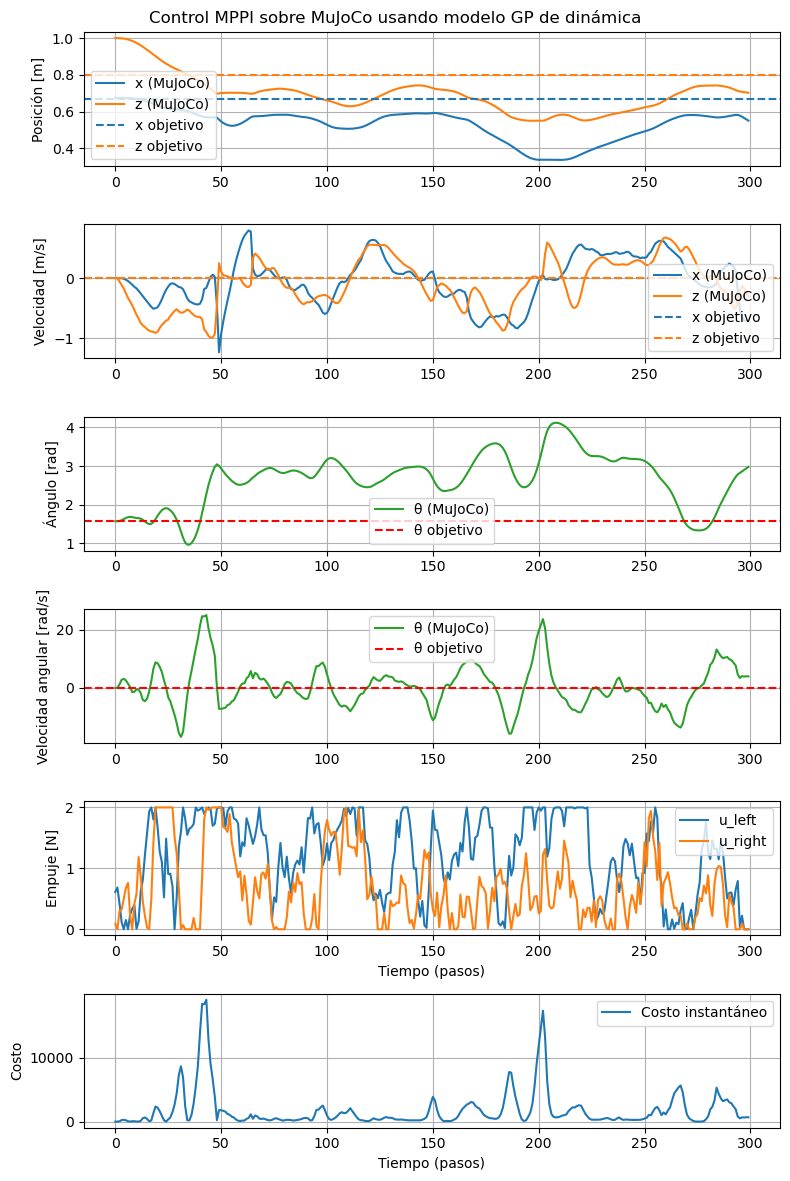

In [12]:
# =====================================================
# 5️⃣ Gráficos de estado / acción / costo
# =====================================================
fig, axes = plt.subplots(6, 1, figsize=(8, 12))

# 1) Posición x, z
axes[0].plot(traj_s[:,0], label="x (MuJoCo)", color='C0')
axes[0].plot(traj_s[:,1], label="z (MuJoCo)", color='C1')
axes[0].axhline(goal[0], color='C0', linestyle='--', label="x objetivo")
axes[0].axhline(goal[1], color='C1', linestyle='--', label="z objetivo")
axes[0].set_ylabel("Posición [m]")
axes[0].legend()
axes[0].grid()

# 1) Velocidad x, z
axes[1].plot(traj_s[:,2], label="x (MuJoCo)", color='C0')
axes[1].plot(traj_s[:,3], label="z (MuJoCo)", color='C1')
axes[1].axhline(goal[2], color='C0', linestyle='--', label="x objetivo")
axes[1].axhline(goal[3], color='C1', linestyle='--', label="z objetivo")
axes[1].set_ylabel("Velocidad [m/s]")
axes[1].legend(loc='lower right')
axes[1].grid()

# 2) Ángulo θ
axes[2].plot(traj_s[:,4], label="θ (MuJoCo)", color='C2')
axes[2].axhline(goal[4], color='r', linestyle='--', label="θ objetivo")
axes[2].set_ylabel("Ángulo [rad]")
axes[2].legend()
axes[2].grid()

# 2) Velocidad angular θ_dot
axes[3].plot(traj_s[:,5], label="θ (MuJoCo)", color='C2')
axes[3].axhline(goal[5], color='r', linestyle='--', label="θ objetivo")
axes[3].set_ylabel("Velocidad angular [rad/s]")
axes[3].legend()
axes[3].grid()

# 3) Acciones (empujes)
axes[4].plot(traj_u[:,0], label="u_left")
axes[4].plot(traj_u[:,1], label="u_right")
axes[4].set_ylabel("Empuje [N]")
axes[4].set_xlabel("Tiempo (pasos)")
axes[4].legend()
axes[4].grid()

# 4) Costo instantáneo
axes[5].plot(traj_cost, label="Costo instantáneo")
axes[5].set_ylabel("Costo")
axes[5].set_xlabel("Tiempo (pasos)")
axes[5].legend()
axes[5].grid()

plt.suptitle("Control MPPI sobre MuJoCo usando modelo GP de dinámica")
plt.tight_layout()
plt.show()


In [11]:
# =====================================================
# 6️⃣ Animación tipo Pendulum-v1 (si tienes frames)
# =====================================================
if len(frames) > 0:
    fig = plt.figure()
    img = plt.imshow(frames[0])

    renderer.close()  # cerrar el renderer de MuJoCo si no se necesita más

    def animate(i):
        img.set_data(frames[i])
        return [img]

    ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
    plt.close()

    display(HTML(ani.to_html5_video()))

else:
    print("⚠️ No se capturaron frames. Añade tu función de render y apéndalos en 'frames'.")
